## Problem Formalization with pymoo
Define the Multi-Objective Problem
We model the EV control problem with two objectives:

Minimize arrival time T.

Minimize energy consumption E.

Constraints:

Vehicle dynamics (simplified for illustration).

Bounds on control inputs (acceleration).



In [6]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

class EVControlProblem(Problem):
    def __init__(self):
        # Bounds for decision variables (e.g., acceleration profile parameters)
        xl = np.array([0.1, 0.1])  # Lower bounds
        xu = np.array([2.0, 2.0])   # Upper bounds (e.g., max acceleration)

        # 2 objectives (T, E), 2 decision variables, 0 constraints
        super().__init__(n_var=2, n_obj=2, n_constr=0, xl=xl, xu=xu)

    def _evaluate(self, X, out, *args, **kwargs):
        # X: Decision variables (e.g., acceleration parameters)
        # Each row of X is a candidate solution
        T = []  # Arrival time
        E = []  # Energy consumption

        for x in X:
            # Simplified dynamics (replace with your actual model)
            a1, a2 = x  # Example: Two acceleration phases
            t1 = 10 / a1  # Time for phase 1
            t2 = 10 / a2  # Time for phase 2
            total_time = t1 + t2

            # Energy = integral of (acceleration^2) over time (simplified)
            energy = (a1**2) * t1 + (a2**2) * t2

            T.append(total_time)
            E.append(energy)

        out["F"] = np.column_stack([T, E])  # Objectives

problem = EVControlProblem()

## 2. Optimize with NSGA-II
We use the NSGA-II algorithm to generate the Pareto front.

where:

n_gen: current generation (iteration)

n_eval: Total number of function evaluations performed so far. n_eval = 1000 means the objective functions (time and energy) have been evaluated 1000 times cumulatively

n_nds: Number of non-dominated solutions (Pareto-optimal solutions) in the current population.


eps:Epsilon (ε) progress metric, measuring the improvement between generations.

Interpretation:

Smaller values (e.g., 0.001) indicate minimal improvement (converging).

Larger values (e.g., 0.02) suggest significant changes in the Pareto front.

Note: - means no value was computed (typically in the first generation).



indicator

Meaning: Reference point used to compute eps. It shows which criterion (ideal point, nadir point, or other) triggered the epsilon value.

Possible Values:

ideal: Improvement relative to the ideal point (best possible values for each objective).

nadir: Improvement relative to the nadir point (worst values on the Pareto front).

f: Generic improvement metric (often based on objective space distances).




In [7]:
algorithm = NSGA2(pop_size=100)  # Larger population for more solutions
result = minimize(
    problem,
    algorithm,
    ('n_gen', 200),  # Number of generations
    seed=42,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      100 |     35 |             - |             -
     2 |      200 |     58 |  0.0215079168 |         ideal
     3 |      300 |     88 |  0.0180306508 |         ideal
     4 |      400 |    100 |  0.0184573539 |         nadir
     5 |      500 |    100 |  0.0232223326 |         ideal
     6 |      600 |    100 |  0.0024572977 |             f
     7 |      700 |    100 |  0.0048893685 |             f
     8 |      800 |    100 |  0.0025861178 |         ideal
     9 |      900 |    100 |  0.0033884408 |         ideal
    10 |     1000 |    100 |  0.0028111864 |         ideal
    11 |     1100 |    100 |  0.0137262180 |         nadir
    12 |     1200 |    100 |  0.0118095078 |         nadir
    13 |     1300 |    100 |  0.0039360396 |         nadir
    14 |     1400 |    100 |  0.0013102609 |             f
    15 |     1500 |    100 |  0.0057717863 |         nadir
    16 |     1600 |    100 |  0.0018703433 |            

In [20]:
# Show first 5 pareto-solutions
print(f"All solutions shape: {result.F.shape}")  # e.g., (2000, 2)
print("First 5 solutions (Time, Energy):")
print(result.F[:5])

All solutions shape: (100, 2)
First 5 solutions (Time, Energy):
[[ 10.          40.        ]
 [200.           2.        ]
 [ 15.52461954  25.89032663]
 [193.40409964   2.06843272]
 [ 16.46865118  24.45769057]]


## 3. Extract and Visualize Pareto Solutions
Get Non-Dominated Solutions


In [8]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

# Extract all solutions
F = result.F  # Objective values (T, E)

# Filter non-dominated solutions
nds_indices = NonDominatedSorting().do(F)
pareto_front = F[nds_indices]

print(f"Found {len(pareto_front)} Pareto-optimal solutions.")


Found 1 Pareto-optimal solutions.


### Visualize the Pareto Front


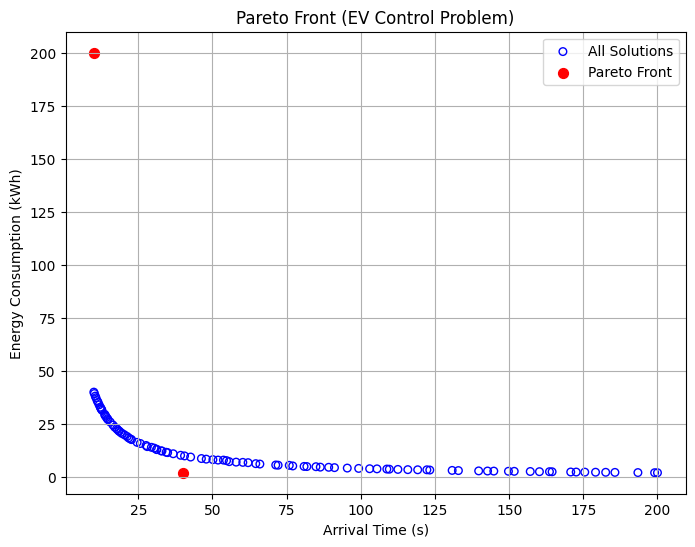

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(F[:, 0], F[:, 1], s=30, facecolors='none', edgecolors='blue', label="All Solutions")
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], s=50, c='red', label="Pareto Front")
plt.title("Pareto Front (EV Control Problem)")
plt.xlabel("Arrival Time (s)")
plt.ylabel("Energy Consumption (kWh)")
plt.legend()
plt.grid(True)
plt.show()